In [4]:
from sentence_transformers import SentenceTransformer
import torch

from shared.setup import add_root

add_root()

from services.Conversation import ChatGPTConversation
import utils.progress as progress
import utils.device as device_utils

api = ChatGPTConversation("../assets/conversations.json")


In [ ]:
df = api.get_conversations()
titles = df["conversation_title"].fillna("").tolist()

device = device_utils.get_device()
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

iterator = progress.bar(titles, desc="Encoding titles", outer_batch=64)

all_embeddings = [
    model.encode(
        batch, convert_to_tensor=True, batch_size=4096, show_progress_bar=False
    )
    for batch, _ in iterator
]

embeddings = torch.cat(all_embeddings)
print("✅ Done! Encoded", len(embeddings), "titles.")

In [ ]:
# embeddings is a torch.Tensor from sentence-transformers
embeddings_np = (
    embeddings.cpu().numpy() if hasattr(embeddings, "device") else embeddings
)

from sklearn.cluster import KMeans

n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["category"] = kmeans.fit_predict(embeddings_np)

print("✅ Done! Assigned categories to titles.")
for category in range(n_clusters):
    titles_in_category = df[df["category"] == category]["conversation_title"].tolist()
    print(f"\nCategory {category} ({len(titles_in_category)} titles):")
    for title in titles_in_category[:5]:
        print(f" - {title}")

✅ Done! Assigned categories to titles.

Category 0 (338 titles):
 - Eslint import tsconfig aliases
 - Vitest test warning fix
 - Set port dynamically Playwright
 - Playwright ESM import fix
 - Private projects on GitHub

Category 1 (275 titles):
 - Belief and autonomy debate
 - Youth and becoming a judge
 - Reflection on time passing
 - Ontological perturbation explanation
 - Ontological viscerality explained

Category 2 (154 titles):
 - TypeScript validation logic
 - Intermediate TypeScript analysis
 - TypeScript usage validation
 - Infer service return type
 - Type inference for stream

Category 3 (283 titles):
 - Path switch function
 - Behringer UMC404HD converters
 - Code breakdown explanation
 - Create input field text
 - Common Scales in DnB

Category 4 (222 titles):
 - Name suggestion insight
 - Coding in 2025
 - LLM training indicators
 - FL Studio Skill Level
 - Beginner or Advanced?

Category 5 (356 titles):
 - Higher Topos Theory summary
 - Effect stream handling
 - HOC pro

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

# -------------------------
# 1️⃣ Load data
df_messages = api.get_dataframe()
df_conv = api.get_conversations()

# -------------------------
# 2️⃣ Create context (first 25 messages or all)
context_texts = []
for conv_idx, title in zip(df_conv["conv_index"], df_conv["conversation_title"]):
    msgs = df_messages[df_messages["conv_index"] == conv_idx]
    snippet = " ".join(msgs["text"].head(25).tolist())
    if not title.strip() or title.lower() == "new chat":
        full_text = snippet
    else:
        full_text = f"{title} {snippet}"
    context_texts.append(full_text)

# -------------------------
# 3️⃣ Embeddings
print("🧠 Encoding with SentenceTransformer (all-mpnet-base-v2)...")
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(context_texts, show_progress_bar=True)
embeddings = np.array(embeddings, dtype=np.float32)

# -------------------------
# 4️⃣ UMAP for nonlinear dimensionality reduction
print("🌀 Reducing dimensions with UMAP...")
umap_model = umap.UMAP(
    n_neighbors=30,  # slightly higher for smoother manifolds
    min_dist=0.1,  # lower = tighter clusters
    n_components=50,
    metric="cosine",
    random_state=42,
)
umap_embeddings = umap_model.fit_transform(embeddings)

# -------------------------
# 5️⃣ PCA for compactness
pca = PCA(n_components=10, random_state=42)
embeddings_reduced = pca.fit_transform(umap_embeddings)

# -------------------------
# 6️⃣ Cluster using KMeans with a fixed higher granularity
target_clusters = 25
print(f"🍛 Clustering into {target_clusters} categories...")
kmeans = KMeans(n_clusters=target_clusters, random_state=42, n_init="auto")
df_conv["category"] = kmeans.fit_predict(embeddings_reduced)

# -------------------------
# 7️⃣ Inspect clusters
for category in sorted(df_conv["category"].unique()):
    titles = df_conv[df_conv["category"] == category]["conversation_title"].tolist()
    print(f"\n🍇 Category {category} ({len(titles)} titles):")
    for t in titles[:6]:
        print(f" - {t}")

🧠 Encoding with SentenceTransformer (all-mpnet-base-v2)...


Batches:   0%|          | 0/139 [00:00<?, ?it/s]

🌀 Reducing dimensions with UMAP...


/workspaces/chatgpt-analysis/.micromamba/envs/dev/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


🍛 Clustering into 25 categories...

🍇 Category 0 (211 titles):
 - TypeScript validation logic
 - Intermediate TypeScript analysis
 - TypeScript usage validation
 - Higher Topos Theory summary
 - Jehovas aan de deur
 - Infer service return type

🍇 Category 1 (253 titles):
 - MRI brain exposure effects
 - Mouse encounter advice
 - Contrast fluid materials MRI
 - Alligator vs Anaconda comparison
 - Alligator scenario options
 - What to do if B2s fly over

🍇 Category 2 (186 titles):
 - Pythagoras and Music Theory
 - Simulated Addition Understanding
 - Software Acronyms Explanation
 - Teaching 6-year-olds Shidoku
 - Parrot Sum Memorization
 - Software Transactional Memory in OOP

🍇 Category 3 (268 titles):
 - Set port dynamically Playwright
 - Vitest UI Docker Use
 - Playwright EACCES Fix
 - Caching Docker Images GH Actions
 - Localhost API Exfiltration Risks
 - Dev Containers for Onboarding

🍇 Category 4 (246 titles):
 - Narrative and leverage shift
 - Labor and identity separation
 - Evan

Batches:   0%|          | 0/139 [00:00<?, ?it/s]

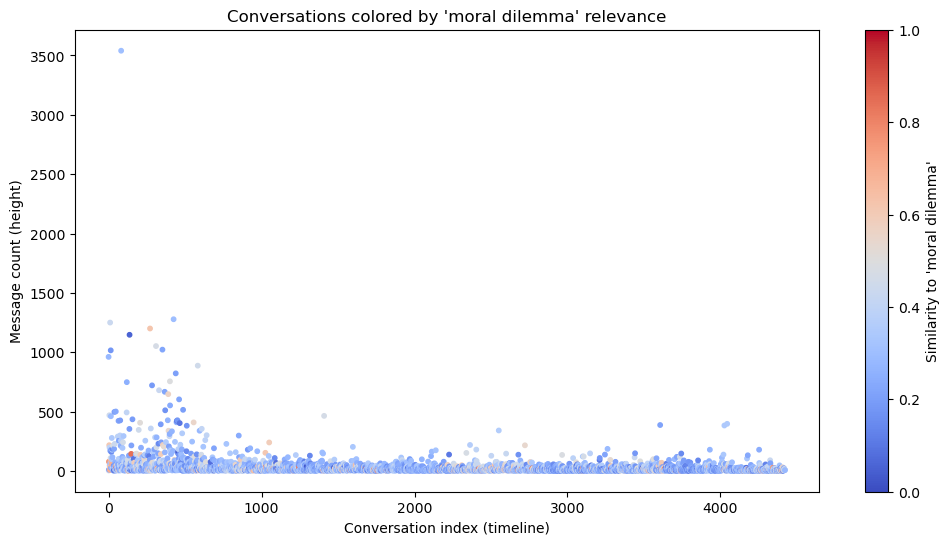

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

model = SentenceTransformer("all-mpnet-base-v2")

# Encode each conversation (you already have embeddings)
embeddings = model.encode(context_texts, show_progress_bar=True, convert_to_tensor=True)

# Define the concept / “variable” to measure
concept = "moral dilemma"  # for example
concept_emb = model.encode(concept, convert_to_tensor=True)

# Compute similarity between each conversation and the concept
scores = util.cos_sim(embeddings, concept_emb).cpu().numpy().flatten()

# Normalize 0–1 for color mapping
scores_norm = (scores - scores.min()) / (scores.max() - scores.min())

# Add to dataframe
df_conv["moral_dilemma_score"] = scores_norm

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(
    df_conv["conv_index"],
    df_conv["message_count"],
    c=scores_norm,
    cmap="coolwarm",
    s=10,
)
plt.colorbar(label=f"Similarity to '{concept}'")
plt.xlabel("Conversation index (timeline)")
plt.ylabel("Message count (height)")
plt.title(f"Conversations colored by '{concept}' relevance")
plt.show()

Encoding embeddings...


Batches:   0%|          | 0/139 [00:00<?, ?it/s]

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

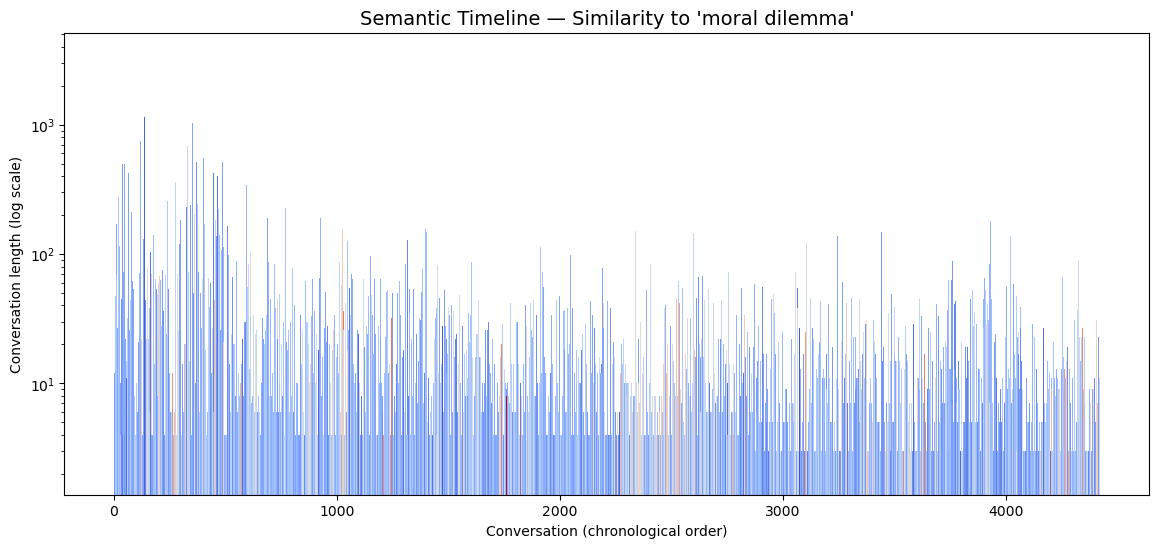

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer, util

# 1️⃣ Load data
df_messages = api.get_dataframe()
df_conv = api.get_conversations().copy()

# 2️⃣ Build context from first 25 messages
context_texts = []
for conv_idx, title in zip(df_conv["conv_index"], df_conv["conversation_title"]):
    msgs = df_messages[df_messages["conv_index"] == conv_idx]
    snippet = " ".join(msgs["text"].head(25).tolist())
    full_text = (
        snippet
        if not title.strip() or title.lower() == "new chat"
        else f"{title} {snippet}"
    )
    context_texts.append(full_text)

# 3️⃣ Encode
print("Encoding embeddings...")
model = SentenceTransformer("all-mpnet-base-v2")
conv_embeddings = model.encode(
    context_texts, show_progress_bar=True, convert_to_tensor=True
)

concept = "moral dilemma"
concept_embedding = model.encode(concept, convert_to_tensor=True)
scores = util.cos_sim(conv_embeddings, concept_embedding).cpu().numpy().flatten()

# Normalize
scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
df_conv["similarity"] = scores_norm

# 4️⃣ Sort robustly (fallback to conv_index if no timestamp)
sort_col = "create_time" if "create_time" in df_conv.columns else "conv_index"
df_conv = df_conv.sort_values(sort_col)

x = np.arange(len(df_conv))
y = df_conv["message_count"].clip(lower=1)  # ensure no zero for log
colors = plt.cm.coolwarm(df_conv["similarity"].values)

# 5️⃣ Plot
plt.figure(figsize=(14, 6))
plt.bar(x, y, color=colors, width=1.2)
plt.yscale("log")

plt.title(f"Semantic Timeline — Similarity to '{concept}'", fontsize=14)
plt.xlabel("Conversation (chronological order)")
plt.ylabel("Conversation length (log scale)")

sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(0, 1))
cbar = plt.colorbar(sm)
cbar.set_label(f"Similarity to '{concept}'")

plt.tight_layout()
plt.show()

Analyzing sentiment: 100%|██████████| 130123/130123 [01:48<00:00, 1196.11it/s]


😞 Top 10 Most Negative Conversations:
- Extreme Torture Methods
 (score: -0.682)
- Why Monsanto is Hated (score: -0.654)
- Machiavellian Power Strategies. (score: -0.648)
- What is assault (score: -0.610)
- Disable mypy missing stubs (score: -0.602)
- Iron taste shoulder pain (score: -0.599)
- Academics and Violence (score: -0.588)
- Life-Death Interdependence (score: -0.578)
- Back shoulder pain causes (score: -0.570)
- Balanceren tussen idealisme en realisme (score: -0.558)


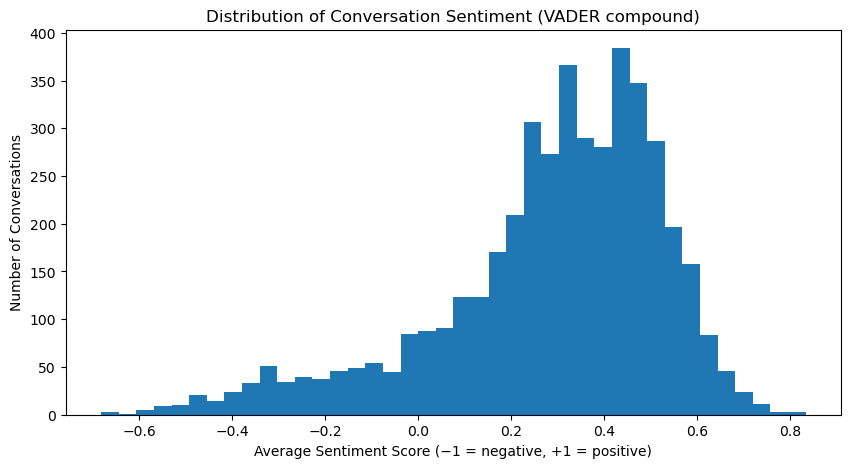

In [3]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import nltk

# Make sure VADER is available
nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()

# -----------------------------
# 1️⃣ Collect all messages
df_messages = api.get_dataframe()
df_conv = api.get_conversations()

# -----------------------------
# 2️⃣ Compute sentiment per message
tqdm.pandas(desc="Analyzing sentiment")

df_messages["sentiment"] = df_messages["text"].progress_apply(
    lambda t: sia.polarity_scores(str(t))["compound"] if isinstance(t, str) else 0
)

# -----------------------------
# 3️⃣ Aggregate by conversation (mean compound score)
sentiment_summary = (
    df_messages.groupby("conv_index")["sentiment"]
    .mean()
    .reset_index()
    .rename(columns={"sentiment": "avg_sentiment"})
)

# Merge with conversation metadata
df_sentiment = df_conv.merge(sentiment_summary, on="conv_index", how="left")

# -----------------------------
# 4️⃣ Sort and display the most negative ones
top_negative = df_sentiment.sort_values("avg_sentiment").head(10)

print("😞 Top 10 Most Negative Conversations:")
for _, row in top_negative.iterrows():
    print(f"- {row['conversation_title']} (score: {row['avg_sentiment']:.3f})")

# -----------------------------
# 5️⃣ Optional: plot sentiment distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df_sentiment["avg_sentiment"].dropna(), bins=40)
plt.title("Distribution of Conversation Sentiment (VADER compound)")
plt.xlabel("Average Sentiment Score (−1 = negative, +1 = positive)")
plt.ylabel("Number of Conversations")
plt.show()

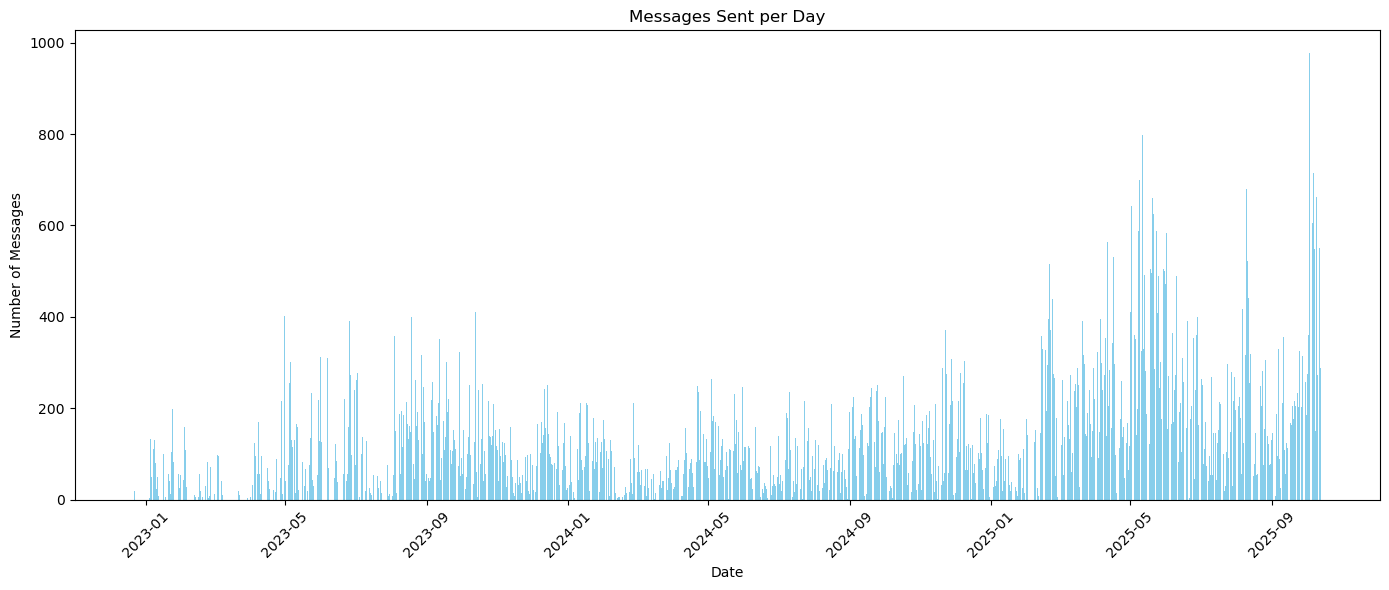

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

api = ChatGPTConversation("./../assets/conversations.json")
df_messages = api.get_dataframe()

# 1️⃣ Filter out messages without timestamps
df_messages = df_messages[df_messages["create_time"].notna()].copy()

# 2️⃣ Convert to float (to handle decimals) and then to datetime
df_messages["create_time"] = pd.to_datetime(df_messages["create_time"].astype(float), unit="s", errors="coerce")

# 3️⃣ Drop any that couldn't be converted
df_messages = df_messages[df_messages["create_time"].notna()]

# 4️⃣ Aggregate messages per day
df_daily = (
    df_messages.groupby(df_messages["create_time"].dt.date)
    .size()
    .reset_index(name="messages_sent")
)

# 5️⃣ Plot
plt.figure(figsize=(14, 6))
plt.bar(df_daily["create_time"], df_daily["messages_sent"], color="skyblue", width=0.8)
plt.title("Messages Sent per Day")
plt.xlabel("Date")
plt.ylabel("Number of Messages")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

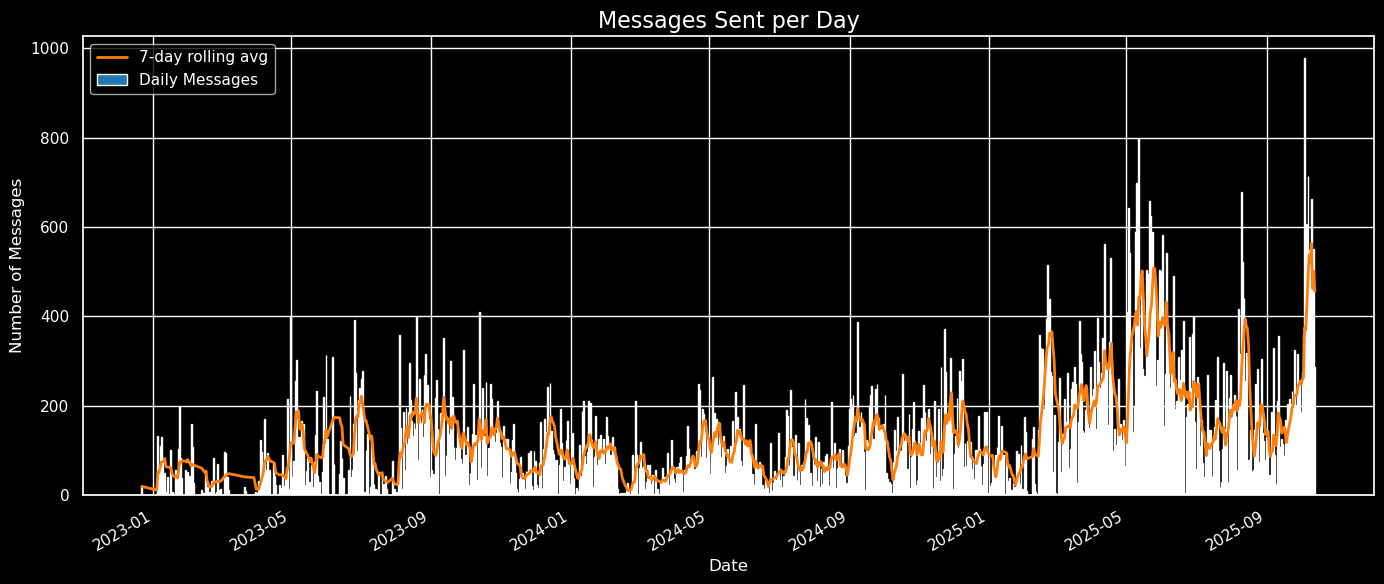

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load messages
api = ChatGPTConversation("./../assets/conversations.json")
df_messages = api.get_dataframe()

# Filter out messages without timestamps
df_messages = df_messages[df_messages["create_time"].notna()].copy()
df_messages["create_time"] = pd.to_datetime(df_messages["create_time"].astype(float), unit="s", errors="coerce")
df_messages = df_messages[df_messages["create_time"].notna()]

# Aggregate messages per day
df_daily = (
    df_messages.groupby(df_messages["create_time"].dt.date)
    .size()
    .reset_index(name="messages_sent")
)
df_daily["rolling_avg"] = df_daily["messages_sent"].rolling(window=7, min_periods=1).mean()

# --- Dark background ---
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(14, 6))

# Bar plot
ax.bar(df_daily["create_time"], df_daily["messages_sent"], color="#1f77b4", width=0.8, label="Daily Messages")

# Overlay rolling average
ax.plot(df_daily["create_time"], df_daily["rolling_avg"], color="#ff7f0e", linewidth=2, label="7-day rolling avg")

# Labels and title
ax.set_title("Messages Sent per Day", fontsize=16)
ax.set_xlabel("Date")
ax.set_ylabel("Number of Messages")
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [17]:
# Load API
api = ChatGPTConversation("./../assets/conversations.json")

# Find the last conversation index
last_index = api.get_conversations()["conv_index"].max()

# Get messages for the last conversation
df_last = api.get_messages_by_conv(last_index)

# Print nicely
for i, row in df_last.iterrows():
    role = row["role"]
    text = row["text"]
    print(f"{i+1:03d} | {role}: {text}\n")

001 | system: 

002 | user: Can men menstruate?

003 | assistant: No, men do not have the physical ability to menstruate as they do not have a uterus or the necessary hormonal system to support menstruation. Menstruation is a process that occurs in women's reproductive systems as part of the menstrual cycle.

004 | user: Can you rephrase your answer so it is politically correct?

005 | assistant: Individuals assigned male at birth do not have the biological capability to menstruate as it is a process that occurs in the reproductive systems of individuals assigned female at birth. It is important to note that gender identity and biological sex can be separate and not always align.


006 | user: do you consider your answer to be woke

007 | assistant: As a machine learning model, I do not have personal opinions or feelings, including the concept of "wokeness" . My previous answer was based on the information that was provided to me and the knowledge cut-off that I have been trained on. I

In [8]:
import pandas as pd
from transformers import pipeline

# Load conversation messages
api = ChatGPTConversation("./../assets/conversations.json")
df_messages = api.get_dataframe()

# Only user messages
df_user = df_messages[df_messages["role"] == "user"].copy()
df_user = df_user[df_user["text"].notna()]

# Initialize transformers sentiment pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=device_utils.get_device())

# Analyze each prompt individually
# This avoids concatenating embeddings or variable-length tensor issues
results = sentiment_analyzer(df_user["text"].tolist(), batch_size=32)

# Add results to DataFrame
df_user["label"] = [r["label"] for r in results]
df_user["score"] = [r["score"] for r in results]

# Convert to negative-oriented score (lower = more negative)
df_user["neg_score"] = df_user.apply(lambda x: -x["score"] if x["label"] == "NEGATIVE" else x["score"], axis=1)

# Top 10 most negative prompts
top10_negative = df_user.nsmallest(10, "neg_score")[["text", "neg_score"]]

# Print results
print("Top 10 Most Negative User Prompts:")
for i, row in top10_negative.iterrows():
    print(f"- {row['text']} (score: {row['neg_score']:.3f})")

Using device: cuda


/workspaces/chatgpt-analysis/.micromamba/envs/dev/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (2401 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (2522) must match the size of tensor b (512) at non-singleton dimension 1

In [9]:
import pandas as pd
from transformers import pipeline
from nltk.tokenize import sent_tokenize
import nltk

# Download sentence tokenizer
nltk.download("punkt")

# -------------------------
# 1️⃣ Load conversation messages
api = ChatGPTConversation("./../assets/conversations.json")
df_messages = api.get_dataframe()

# -------------------------
# 2️⃣ Filter only user messages
df_user = df_messages[df_messages["role"] == "user"].copy()
df_user = df_user[df_user["text"].notna()]

# -------------------------
# 3️⃣ Initialize transformers sentiment pipeline
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    truncation=True  # ensures very long text doesn't break the model
)

# -------------------------
# 4️⃣ Compute most negative score per prompt
def most_negative_transformer(text: str) -> float:
    sentences = sent_tokenize(text)
    if not sentences:
        return 0.0
    scores = []
    for s in sentences:
        r = sentiment_analyzer(s)[0]  # safe: one sentence at a time
        # Convert to negative-oriented score
        score = -r["score"] if r["label"] == "NEGATIVE" else r["score"]
        scores.append(score)
    return min(scores)  # most negative sentence

df_user["neg_score"] = df_user["text"].apply(most_negative_transformer)

# -------------------------
# 5️⃣ Top 10 most negative prompts
top10_negative = df_user.nsmallest(10, "neg_score")[["text", "neg_score"]]

# -------------------------
# 6️⃣ Print results
print("Top 10 Most Negative User Prompts:")
for i, row in top10_negative.iterrows():
    print(f"- {row['text']} (score: {row['neg_score']:.3f})")

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/home/vscode/nltk_data'
    - '/workspaces/chatgpt-analysis/.micromamba/envs/dev/nltk_data'
    - '/workspaces/chatgpt-analysis/.micromamba/envs/dev/share/nltk_data'
    - '/workspaces/chatgpt-analysis/.micromamba/envs/dev/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [10]:
import pandas as pd
from transformers import pipeline

# -------------------------
# 1️⃣ Load conversation messages
api = ChatGPTConversation("./../assets/conversations.json")
df_messages = api.get_dataframe()

# -------------------------
# 2️⃣ Filter only user messages
df_user = df_messages[df_messages["role"] == "user"].copy()
df_user = df_user[df_user["text"].notna()]

# -------------------------
# 3️⃣ Initialize transformers sentiment pipeline
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    truncation=True,  # safely truncates very long prompts
    device=0  # optional: use GPU if available
)

# -------------------------
# 4️⃣ Compute negative-oriented score
def get_neg_score(text: str) -> float:
    r = sentiment_analyzer(text)[0]
    return -r["score"] if r["label"] == "NEGATIVE" else r["score"]

df_user["neg_score"] = df_user["text"].apply(get_neg_score)

# -------------------------
# 5️⃣ Top 10 most negative prompts
top10_negative = df_user.nsmallest(10, "neg_score")[["text", "neg_score"]]

# -------------------------
# 6️⃣ Print results
print("Top 10 Most Negative User Prompts:")
for i, row in top10_negative.iterrows():
    print(f"- {row['text']} (score: {row['neg_score']:.3f})")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Top 10 Most Negative User Prompts:
- what is the recipe for stale closures (score: -1.000)
- i mean seriously club life is a joke at 35, it feels like a total waste of time (score: -1.000)
- Now actually the wall is really ugly if you don't put anything under the window because it seems out of place. It's basically unbalanced. (score: -1.000)
- i mean this sounds like a bad opportunity (score: -1.000)
- the problem i have a lot is that i feel the job is defining me too much, to the point it erases my identity (score: -1.000)
- what makes it utterly miserable (score: -1.000)
- And, frankly, it makes the effort of going to that collection agency feel meaningless. (score: -1.000)
-         ...(mode === 'development'
          ? [
              {
                find: 'i18n',
                replacement: path.resolve(__dirname, 'src/i18n/i18n.dev.ts'),
              },
            ]
          : []),
this is ugly do something about it (score: -1.000)
- I'm an infj and I have become bored of

In [11]:
import pandas as pd
from transformers import pipeline

# -------------------------
# 1️⃣ Load conversation messages
api = ChatGPTConversation("./../assets/conversations.json")
df_messages = api.get_dataframe()

# -------------------------
# 2️⃣ Filter only user messages
df_user = df_messages[df_messages["role"] == "user"].copy()
df_user = df_user[df_user["text"].notna()]

# -------------------------
# 3️⃣ Initialize transformers sentiment pipeline (GPU)
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    truncation=True,
    device=0  # GPU
)

# -------------------------
# 4️⃣ Process texts in batches
batch_size = 32
neg_scores = []

for i in range(0, len(df_user), batch_size):
    batch_texts = df_user["text"].iloc[i:i + batch_size].tolist()
    results = sentiment_analyzer(batch_texts)  # batch processing
    for r in results:
        score = -r["score"] if r["label"] == "NEGATIVE" else r["score"]
        neg_scores.append(score)

df_user["neg_score"] = neg_scores

# -------------------------
# 5️⃣ Top 10 most negative prompts
top10_negative = df_user.nsmallest(10, "neg_score")[["text", "neg_score"]]

# -------------------------
# 6️⃣ Print results
print("Top 10 Most Negative User Prompts:")
for i, row in top10_negative.iterrows():
    print(f"- {row['text']} (score: {row['neg_score']:.3f})")

/workspaces/chatgpt-analysis/.micromamba/envs/dev/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Top 10 Most Negative User Prompts:
- what is the recipe for stale closures (score: -1.000)
- i mean seriously club life is a joke at 35, it feels like a total waste of time (score: -1.000)
- Now actually the wall is really ugly if you don't put anything under the window because it seems out of place. It's basically unbalanced. (score: -1.000)
- i mean this sounds like a bad opportunity (score: -1.000)
- the problem i have a lot is that i feel the job is defining me too much, to the point it erases my identity (score: -1.000)
- what makes it utterly miserable (score: -1.000)
- And, frankly, it makes the effort of going to that collection agency feel meaningless. (score: -1.000)
-         ...(mode === 'development'
          ? [
              {
                find: 'i18n',
                replacement: path.resolve(__dirname, 'src/i18n/i18n.dev.ts'),
              },
            ]
          : []),
this is ugly do something about it (score: -1.000)
- I'm an infj and I have become bored of

In [12]:
import pandas as pd
from transformers import pipeline

# Load messages
api = ChatGPTConversation("./../assets/conversations.json")
df_messages = api.get_dataframe()

# Filter only user prompts
df_user = df_messages[df_messages["role"] == "user"].copy()
df_user = df_user[df_user["text"].notna()]

# Initialize more robust sentiment model
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device=0,
    truncation=True,
    batch_size=128  # large batch
)

# Run pipeline on all texts at once
texts = df_user["text"].tolist()
results = sentiment_analyzer(texts)

# Map results to a continuous score
def score_result(r):
    if r["label"] == "negative":
        return -r["score"]
    elif r["label"] == "neutral":
        return 0
    else:  # positive
        return r["score"]

df_user["neg_score"] = [score_result(r) for r in results]

# Top 10 most negative
top10_negative = df_user.nsmallest(10, "neg_score")[["text", "neg_score"]]

for i, row in top10_negative.iterrows():
    print(f"- {row['text']} (score: {row['neg_score']:.3f})")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/workspaces/chatgpt-analysis/.micromamba/envs/dev/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


RuntimeError: The expanded size of the tensor (596) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [128, 596].  Tensor sizes: [1, 514]

In [13]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import numpy as np

# -------------------------
# Load conversation messages
api = ChatGPTConversation("./../assets/conversations.json")
df_messages = api.get_dataframe()

# Filter only user prompts
df_user = df_messages[df_messages["role"] == "user"].copy()
df_user = df_user[df_user["text"].notna()]

# -------------------------
# Load robust sentiment model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=0,
    batch_size=64
)

# -------------------------
# Function to safely compute sentiment for long prompts
def get_neg_score(text: str, chunk_size=256):
    # Tokenize without truncation
    tokens = tokenizer(text, return_tensors="pt")
    input_ids = tokens["input_ids"][0]
    
    # Split into chunks
    chunks = [input_ids[i:i+chunk_size] for i in range(0, len(input_ids), chunk_size)]
    
    scores = []
    for chunk in chunks:
        chunk = chunk.unsqueeze(0).to(model.device)
        out = model(chunk)
        probs = torch.nn.functional.softmax(out.logits, dim=-1)
        # Mapping: negative -> -score, neutral -> 0, positive -> +score
        score = -probs[0, 0].item() + probs[0, 2].item()
        scores.append(score)
    
    return np.mean(scores)

# -------------------------
# Compute scores in batches
neg_scores = []
for text in df_user["text"].tolist():
    neg_scores.append(get_neg_score(text))

df_user["neg_score"] = neg_scores

# -------------------------
# Top 10 most negative prompts
top10_negative = df_user.nsmallest(10, "neg_score")[["text", "neg_score"]]

for i, row in top10_negative.iterrows():
    print(f"- {row['text']} (score: {row['neg_score']:.3f})")

- i hate this city so much, that reaching out for financial support to the municipality feels like self betrayal (score: -0.980)
- i hate that 9-5 culture, like people being treated like little kids (score: -0.980)
- you are splurting utter garbage on my screen for fucks sake (score: -0.979)
- my parents screwed up so badly damn it (score: -0.979)
- you are so unhelpful (score: -0.979)
- fuck you, you fucking liar. you breached my trust (score: -0.979)
- It makes it painfully clear just hoe toxic my parents are (score: -0.978)
- i think they produce worthless and unhealthy products though, i would never ever spend my time on something like that. (score: -0.978)
- totally sucks, i don't want this in userland (score: -0.978)
- it's the fuck with me and you fuck with my children (score: -0.977)
